# Load Dataset

In [1]:
!pip install -q datasets

from datasets import load_dataset 


In [2]:
# Load dataset
seed = 42
dataset = load_dataset("imagenet_sketch")

train_dev_test_split = dataset['train'].train_test_split(test_size=0.3, seed=seed)
dev_test_split = train_dev_test_split['test'].train_test_split(test_size=0.5, seed=seed)

train_dataset = train_dev_test_split['train']
dev_dataset = dev_test_split['train']
test_dataset = dev_test_split['test']

Found cached dataset imagenet_sketch (/home/yash/.cache/huggingface/datasets/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /home/yash/.cache/huggingface/datasets/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e/cache-1e2c743a1b8e94f4.arrow and /home/yash/.cache/huggingface/datasets/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e/cache-42fafcef8adc75b2.arrow
Loading cached split indices for dataset at /home/yash/.cache/huggingface/datasets/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e/cache-fc63262862d24131.arrow and /home/yash/.cache/huggingface/datasets/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e/cache-f2442f13ad24f47d.arrow


In [3]:
labels = train_dataset.features["label"].names
num_labels = len(train_dataset.features["label"].names)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'tench, Tinca tinca': 0, 'goldfish, Carassius auratus': 1, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias': 2, 'tiger shark, Galeocerdo cuvieri': 3, 'hammerhead, hammerhead shark': 4, 'electric ray, crampfish, numbfish, torpedo': 5, 'stingray': 6, 'cock': 7, 'hen': 8, 'ostrich, Struthio camelus': 9, 'brambling, Fringilla montifringilla': 10, 'goldfinch, Carduelis carduelis': 11, 'house finch, linnet, Carpodacus mexicanus': 12, 'junco, snowbird': 13, 'indigo bunting, indigo finch, indigo bird, Passerina cyanea': 14, 'robin, American robin, Turdus migratorius': 15, 'bulbul': 16, 'jay': 17, 'magpie': 18, 'chickadee': 19, 'water ouzel, dipper': 20, 'kite': 21, 'bald eagle, American eagle, Haliaeetus leucocephalus': 22, 'vulture': 23, 'great grey owl, great gray owl, Strix nebulosa': 24, 'European fire salamander, Salamandra salamandra': 25, 'common newt, Triturus vulgaris': 26, 'eft': 27, 'spotted salamander, Ambystoma maculatum': 28, 'axolotl, mud pu

In [4]:
labels = train_dataset[0]['label']
print(labels)

858


In [7]:
train_dataset[135]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1009x1024>,
 'label': 416}

In [8]:
dev_dataset[152]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1144x1144>,
 'label': 590}

# Forward Pass ViT Model with a Toy Image

In [10]:
import torch
import torch.nn as nn

# Create toy image with dim (batch x channel x width x height)
toy_img = torch.rand(1, 3, 48, 48)

# Define conv layer parameters
num_channels = 3
hidden_size = 768  # or emb_dimension
patch_size = 16

# Conv 2D layer
projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size,
                       stride=patch_size)

# Forward pass toy img
out_projection = projection(toy_img)

print(f'Original image size: {toy_img.size()}')
print(f'Size after projection: {out_projection.size()}')

Original image size: torch.Size([1, 3, 48, 48])
Size after projection: torch.Size([1, 768, 3, 3])


In [11]:
# Flatten the output after projection with Conv2D layer

patch_embeddings = out_projection.flatten(2).transpose(1, 2)
print(f'Patch embedding size: {patch_embeddings.size()}')

Patch embedding size: torch.Size([1, 9, 768])


In [12]:
# Define [CLS] token embedding with the same emb dimension as the patches
batch_size = 1
cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
cls_tokens = cls_token.expand(batch_size, -1, -1)

# Prepend [CLS] token in the beginning of patch embedding
patch_embeddings = torch.cat((cls_tokens, patch_embeddings), dim=1)
print(f'Patch embedding size: {patch_embeddings.size()}')

Patch embedding size: torch.Size([1, 10, 768])


In [13]:
# Define position embedding with the same dimension as the patch embedding
position_embeddings = nn.Parameter(torch.randn(batch_size, 10, hidden_size))

# Add position embedding into patch embedding
input_embeddings = patch_embeddings + position_embeddings
print(f'Input embedding size: {input_embeddings.size()}')

Input embedding size: torch.Size([1, 10, 768])


In [14]:
# Define parameters for ViT-base (example)
num_heads = 12
num_layers = 12

# Define Transformer encoders' stack
transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=hidden_size, nhead=num_heads,
    dim_feedforward=int(hidden_size * 4),
    dropout=0.1)
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=num_layers)

# Forward pass
output_embeddings = transformer_encoder(input_embeddings)
print(f' Output embedding size: {output_embeddings.size()}')

 Output embedding size: torch.Size([1, 10, 768])


In [15]:
!pip install transformers

from transformers import ViTModel

# Load pretrained model
model_checkpoint = 'google/vit-base-patch16-224-in21k'
model = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)

# Example input image
input_img = torch.rand(batch_size, num_channels, 224, 224)

# Forward pass input image
output_embedding = model(input_img)
print(output_embedding)
print(f"Ouput embedding size: {output_embedding['last_hidden_state'].size()}")

Defaulting to user installation because normal site-packages is not writeable


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.0852, -0.2270,  0.0562,  ...,  0.2189,  0.0376, -0.3539],
         [ 0.1680,  0.0264, -0.0255,  ..., -0.0811,  0.1672, -0.2500],
         [ 0.1187, -0.2603,  0.0697,  ..., -0.0060,  0.2914, -0.3653],
         ...,
         [ 0.1554, -0.1587, -0.0487,  ..., -0.0326,  0.1318, -0.3420],
         [-0.0882, -0.3626, -0.0761,  ...,  0.1686,  0.0089, -0.3452],
         [ 0.1589, -0.0966, -0.0008,  ..., -0.0107,  0.0970, -0.2761]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=None, hidden_states=None, attentions=None)
Ouput embedding size: torch.Size([1, 197, 768])


In [16]:
num_labels = train_dataset.num_rows

# Define linear classifier layer
classifier = nn.Linear(hidden_size, num_labels)

# Forward pass on the output embedding of [CLS] token
output_classification = classifier(
    output_embedding['last_hidden_state'][:, 0, :])
print(f"Output embedding size: {output_classification.size()}")

Output embedding size: torch.Size([1, 35622])


# Fine Tuning ViT Impelementation

In [17]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm


In [18]:
from PIL import Image


class ImageDataset(torch.utils.data.Dataset):

    def __init__(self, input_data):

        self.input_data = input_data
        # Transform input data
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.input_data)

    def get_images(self, idx):
        image_data = self.input_data[idx]['image']
        if not isinstance(image_data, Image.Image):
            image_data = Image.fromarray(image_data)
        
        # Convert grayscale to RGB
        if image_data.mode != 'RGB':
            image_data = image_data.convert('RGB')

        return self.transform(image_data)

    def get_labels(self, idx):
        return self.input_data[idx]['label']

    def __getitem__(self, idx):
        train_images = self.get_images(idx)
        train_labels = self.get_labels(idx)
        return train_images, train_labels

# VIT Transformers Model

In [19]:
class ViT(nn.Module):

    def __init__(self, config=ViTConfig(), num_labels=train_dataset.num_rows,
                 model_checkpoint='google/vit-base-patch16-224-in21k'):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(
            model_checkpoint, add_pooling_layer=False)
        self.classifier = (
            nn.Linear(config.hidden_size, num_labels)
        )

    def forward(self, x):

        x = self.vit(x)['last_hidden_state']
        # Use the embedding of [CLS] token
        output = self.classifier(x[:, 0, :])

        return output

In [20]:
# from lion_pytorch import Lion

In [21]:
class lion_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3, beta1 = 0.9, beta2 = 0.99, lambdaa = 1):
        super(lion_optimizer, self).__init__(params, defaults={'lr': learning_rate})
        self.state = dict()
        self.beta1 = beta1
        self.beta2 = beta2
        self.lambdaa = lambdaa
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(momentum = torch.zeros_like(p.data))

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state: 
                    self.state[p] = dict(momentum = torch.zeros_like(p.data))
                m = self.beta1 * self.state[p]['momentum'] + (1 - self.beta1) * p.grad.data
                p.data -= group['lr'] * (torch.sign(m) + self.lambdaa * p.data)
                m = self.beta2 * self.state[p]['momentum'] + (1 - self.beta2) * p.grad.data
                self.state[p]['momentum'] = m

In [22]:
import torch.optim.adamw

# Training Loop

In [23]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def evaluate_model(model, dataset, criterion, device):
    dataset = ImageDataset(dataset)
    dataloader = DataLoader(dataset, num_workers=1, batch_size=BATCH_SIZE, shuffle=True)
    total_acc, total_loss = 0.0, 0.0

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(dim=1) == labels).sum().item()

            total_acc += acc
            total_loss += loss.item()

    avg_loss = total_loss / len(dataset)
    avg_acc = total_acc / len(dataset)
    return avg_loss, avg_acc

def model_train(train_dataset, dev_dataset, test_dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    # device = torch.device("cpu")

    # Load nodel, loss function, and optimizer
    model = ViT().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = lion_optimizer(model.parameters(), learning_rate=0.00005, beta1 = 0.9, beta2 = 0.99, lambdaa = 0.01)

    # Load batch image
    train_dataset = ImageDataset(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, num_workers=1, batch_size=bs, shuffle=True)

    # Fine tuning loop
    for i in range(epochs):
        total_acc_train = 0
        total_loss_train = 0.0

        model.train()  # Set the model to training mode

        for train_image, train_label in tqdm(train_dataloader):
            output = model(train_image.to(device))
            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        dev_loss, dev_acc = evaluate_model(model, dev_dataset, criterion, device)
        test_loss, test_acc = evaluate_model(model, test_dataset, criterion, device)

        # print(f'Epoch: {i + 1} | Training Loss: {total_loss_train / len(train_dataset): .3f} | Training Accuracy: {total_acc_train / len(train_dataset): .6f} | Dev Accuracy: {dev_acc: .6f} | Test Accuracy: {test_acc: .6f}')
        print(f'Epoch: {i + 1} | Training Loss: {total_loss_train / len(train_dataset): .6f} | Training Accuracy: {total_acc_train / len(train_dataset): .6f} | Dev Loss: {dev_loss: .6f} | Dev Accuracy: {dev_acc: .6f} | Test Loss: {test_loss: .6f} | Test Accuracy: {test_acc: .6f}')

    return model


# Hyperparameters
EPOCHS = 15
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

# Train the model
trained_model = model_train(
    train_dataset, dev_dataset, test_dataset, EPOCHS, LEARNING_RATE, BATCH_SIZE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1114/1114 [16:22<00:00,  1.13it/s]


Epoch: 1 | Training Loss:  0.226688 | Training Accuracy:  0.005727 | Dev Loss:  0.188079 | Dev Accuracy:  0.022141 | Test Loss:  0.188412 | Test Accuracy:  0.020304


100%|██████████| 1114/1114 [16:21<00:00,  1.13it/s]


Epoch: 2 | Training Loss:  0.162663 | Training Accuracy:  0.077059 | Dev Loss:  0.141183 | Dev Accuracy:  0.147124 | Test Loss:  0.141099 | Test Accuracy:  0.144878


100%|██████████| 1114/1114 [16:21<00:00,  1.14it/s]


Epoch: 3 | Training Loss:  0.104520 | Training Accuracy:  0.325698 | Dev Loss:  0.091269 | Dev Accuracy:  0.384384 | Test Loss:  0.091256 | Test Accuracy:  0.383154


100%|██████████| 1114/1114 [16:23<00:00,  1.13it/s]


Epoch: 4 | Training Loss:  0.051604 | Training Accuracy:  0.629695 | Dev Loss:  0.065128 | Dev Accuracy:  0.533080 | Test Loss:  0.064363 | Test Accuracy:  0.533796


100%|██████████| 1114/1114 [14:51<00:00,  1.25it/s]


Epoch: 5 | Training Loss:  0.023868 | Training Accuracy:  0.819185 | Dev Loss:  0.057816 | Dev Accuracy:  0.589676 | Test Loss:  0.058575 | Test Accuracy:  0.582133


100%|██████████| 1114/1114 [14:48<00:00,  1.25it/s]


Epoch: 6 | Training Loss:  0.014169 | Training Accuracy:  0.888889 | Dev Loss:  0.059128 | Dev Accuracy:  0.601336 | Test Loss:  0.058614 | Test Accuracy:  0.596935


100%|██████████| 1114/1114 [14:51<00:00,  1.25it/s]


Epoch: 7 | Training Loss:  0.011402 | Training Accuracy:  0.910561 | Dev Loss:  0.061094 | Dev Accuracy:  0.607101 | Test Loss:  0.061845 | Test Accuracy:  0.602567


100%|██████████| 1114/1114 [13:44<00:00,  1.35it/s]


Epoch: 8 | Training Loss:  0.010675 | Training Accuracy:  0.917298 | Dev Loss:  0.064498 | Dev Accuracy:  0.601336 | Test Loss:  0.064194 | Test Accuracy:  0.600734


100%|██████████| 1114/1114 [13:41<00:00,  1.36it/s]


Epoch: 9 | Training Loss:  0.010247 | Training Accuracy:  0.919881 | Dev Loss:  0.066946 | Dev Accuracy:  0.597930 | Test Loss:  0.067111 | Test Accuracy:  0.595232


100%|██████████| 1114/1114 [13:44<00:00,  1.35it/s]


Epoch: 10 | Training Loss:  0.009883 | Training Accuracy:  0.922127 | Dev Loss:  0.068404 | Dev Accuracy:  0.596882 | Test Loss:  0.069040 | Test Accuracy:  0.592874


100%|██████████| 1114/1114 [13:40<00:00,  1.36it/s]


Epoch: 11 | Training Loss:  0.009236 | Training Accuracy:  0.926815 | Dev Loss:  0.069738 | Dev Accuracy:  0.595703 | Test Loss:  0.069375 | Test Accuracy:  0.586979


100%|██████████| 1114/1114 [13:37<00:00,  1.36it/s]


Epoch: 12 | Training Loss:  0.008959 | Training Accuracy:  0.931784 | Dev Loss:  0.070562 | Dev Accuracy:  0.601729 | Test Loss:  0.069857 | Test Accuracy:  0.599162


100%|██████████| 1114/1114 [13:39<00:00,  1.36it/s]


Epoch: 13 | Training Loss:  0.008496 | Training Accuracy:  0.934675 | Dev Loss:  0.071277 | Dev Accuracy:  0.600157 | Test Loss:  0.070260 | Test Accuracy:  0.606366


100%|██████████| 1114/1114 [13:38<00:00,  1.36it/s]


Epoch: 14 | Training Loss:  0.008195 | Training Accuracy:  0.936360 | Dev Loss:  0.069447 | Dev Accuracy:  0.609983 | Test Loss:  0.070724 | Test Accuracy:  0.607021


100%|██████████| 1114/1114 [13:44<00:00,  1.35it/s]


Epoch: 15 | Training Loss:  0.007690 | Training Accuracy:  0.940935 | Dev Loss:  0.075325 | Dev Accuracy:  0.587056 | Test Loss:  0.074313 | Test Accuracy:  0.597983


# Inbuilt AdamW

In [24]:
torch.save(model.state_dict(), 'ImageNet_Lion_Custom.pth')

# Model Prediction

In [25]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

    img = transform(img)
    output = trained_model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

In [ ]:
print(predict(dataset['test'][900]['image']))

axolotl, mud puppy, Ambystoma mexicanum


/home/yash/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


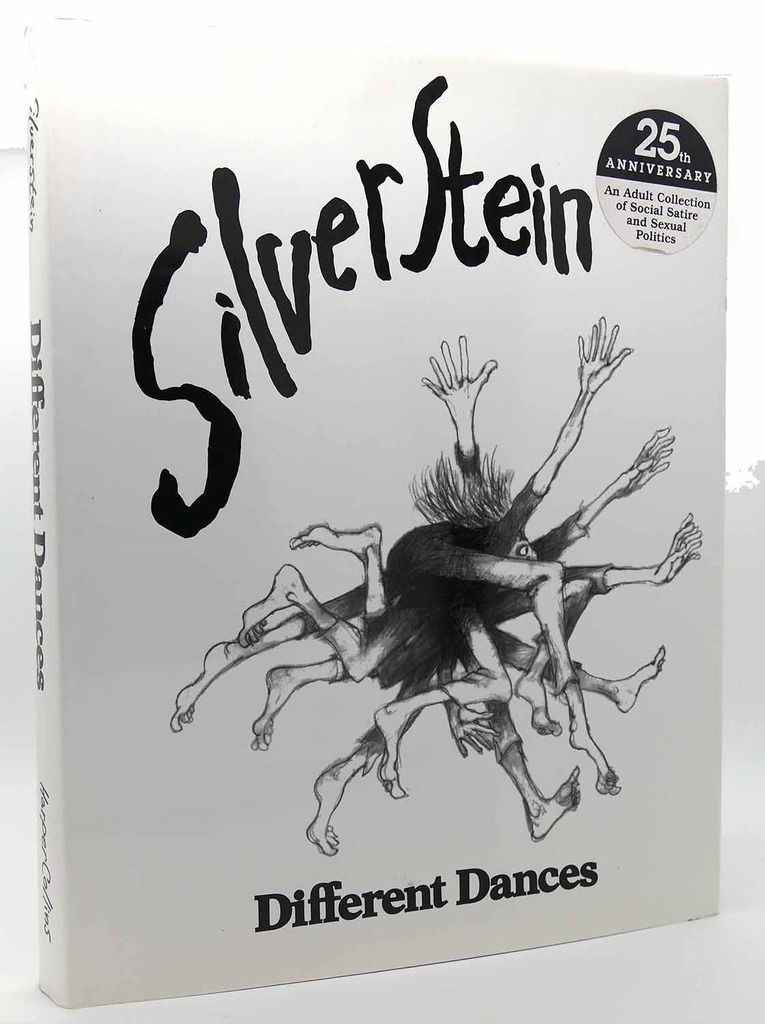

In [ ]:
dataset['test'][250]['image']

In [ ]:
print(predict(dataset['test'][250]['image']))

redshank, Tringa totanus
